# Flight segments from Twin-Otter flights

In [2]:
%load_ext lab_black

In [3]:
#! python -m pip install git+https://github.com/EUREC4A-UK/twin-otter.git#egg=twinotter

In [4]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import xarray as xr
import sys

In [5]:
sys.path.insert(0, "../../")
import masin_processing.create_revision

In [6]:
_cache = {}


def get_TO_data(flight_number, raw_data=False):
    if flight_number not in _cache:
        filepath = masin_processing.create_revision.find_most_recent_processed_version(
            data_root=Path("../../"),
            flight_num=flight_number,
            instrument="MASIN",
            freq="1",
        )

        ds = xr.open_dataset(filepath)
    else:
        ds = _cache[flight_number]

    return ds.rename(dict(Time="time"))

# Correct radar altitude and create composite altitude

In [53]:
ds = get_TO_data(330)

Looking in ../../flight330/MASIN for EUREC4A_TO-330_MASIN-1Hz_*_*.nc


In [54]:
ds.HGT_RADR1

<xarray.DataArray 'HGT_RADR1' (time: 10575)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-24T11:06:37 ... 2020-01-24T14:02:51
Attributes:
    long_name:      Radar height from the aircraft radar altimeter 1.
    units:          m 
    standard_name:  height

In [101]:
z_threshold = 500

if "corrected" not in ds.HGT_RADR1.attrs.get("notes", ""):
    # correct radar altitude
    ds["HGT_RADR1"] = -2.0 * ds.HGT_RADR1
    ds.HGT_RADR1.attrs["notes"] = "corrected -2.0 scaling error from instrument output"

# find points where TO was flying low-level east of Barbados
ds_lowlevel_ocean = (
    ds.where(ds.HGT_RADR1 > 50.0)
    .where(ds.HGT_RADR1 < z_threshold)
    .where(ds.LON_OXTS > -59.4)
)

# compute mean altitude offset between the radar altitude and GPS altitude for these points
da_ocean_offset = (ds_lowlevel_ocean.ALT_OXTS - ds_lowlevel_ocean.HGT_RADR1).mean(
    skipna=True
)

# create a altitude composite using the radar altitude when below 400m
# otherwise use the offset GPS altitude
ds["ALT_OXTS_OFFSET"] = ds.ALT_OXTS - da_ocean_offset
ds.ALT_OXTS_OFFSET.attrs["units"] = "m"
ds.ALT_OXTS_OFFSET.attrs[
    "long_name"
] = f"{ds.ALT_OXTS.long_name} offset with radar below {z_threshold}m altitude to measure ocean-relative height"

ds["ALT_COMPOSITE"] = ds.HGT_RADR1.where(ds.HGT_RADR1 < z_threshold, ds.ALT_OXTS_OFFSET)
ds.ALT_COMPOSITE.attrs["units"] = "m"
ds.ALT_COMPOSITE.attrs[
    "long_name"
] = "altitude relative to ocean surface (radar + gps composite)"

378.60552978515625


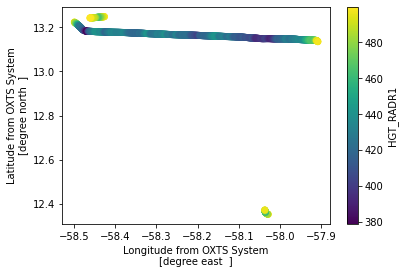

In [102]:
alt_var = "HGT_RADR1"
fig, ax = plt.subplots()
ds_ = ds_lowlevel_ocean

xr.plot.scatter(ds=ds_, x="LON_OXTS", y="LAT_OXTS", hue=alt_var)
print(ds_[alt_var].min().item())

-0.06096000224351883


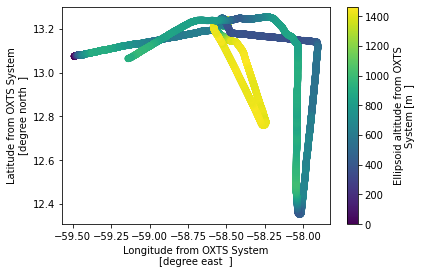

In [103]:
alt_var = "ALT_OXTS"
fig, ax = plt.subplots()

xr.plot.scatter(ds=ds, x="LON_OXTS", y="LAT_OXTS", hue=alt_var, vmin=0)
print(ds.HGT_RADR1.min().item())

-0.06096000224351883


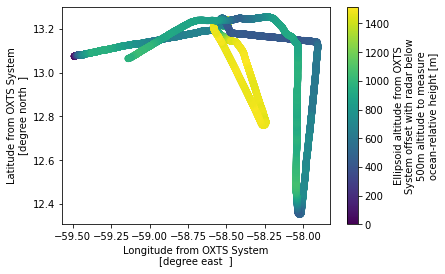

In [104]:
alt_var = "ALT_OXTS_OFFSET"
fig, ax = plt.subplots()

xr.plot.scatter(ds=ds, x="LON_OXTS", y="LAT_OXTS", hue=alt_var, vmin=0)
print(ds.HGT_RADR1.min().item())

-0.06096000224351883


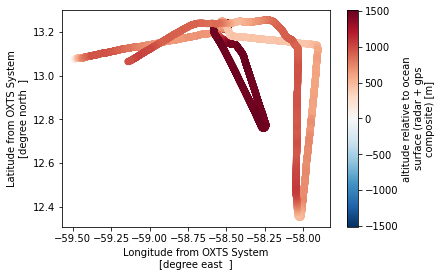

In [105]:
alt_var = "ALT_COMPOSITE"

fig, ax = plt.subplots()

xr.plot.scatter(ds=ds, x="LON_OXTS", y="LAT_OXTS", hue=alt_var)
print(ds[alt_var].min().item())

Text(0, 0.5, 'altitude [m]')

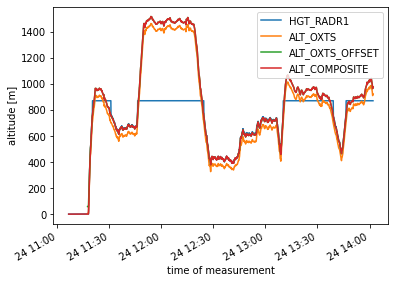

In [96]:
alt_vars = ["HGT_RADR1", "ALT_OXTS", "ALT_OXTS_OFFSET", "ALT_COMPOSITE"]

fig, ax = plt.subplots()

for v in alt_vars:
    ds[v].plot(ax=ax, label=v)

ax.legend()
ax.set_ylabel("altitude [m]")

# Checking MASIN altitude measurements

Looking in ../../flight333/MASIN for EUREC4A_TO-333_MASIN-1Hz_*_*.nc


Text(0.5, 1.0, '333')

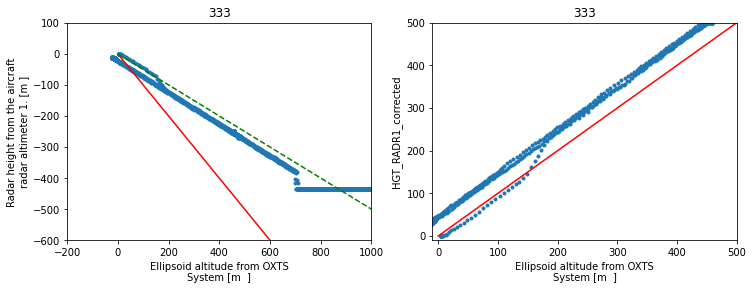

In [13]:
flight_number = "333"
ds = get_TO_data(flight_number, raw_data=True)


fig, axes = plt.subplots(figsize=(12, 4), ncols=2)

ds["HGT_RADR1_corrected"] = -2.0 * ds.HGT_RADR1

ax = axes[0]
xr.plot.scatter(ds, "ALT_OXTS", "HGT_RADR1", marker=".", ax=ax)
ax.set_xlim(-200, 1000)
ax.set_ylim(-600, 100)
x = np.linspace(0, 1000, 100)
ax.plot(x, -x, color="red")
ax.plot(x, -0.5 * x, color="green", linestyle="--")
ax.set_title(ds.flight_number)

ax = axes[1]
xr.plot.scatter(ds, "ALT_OXTS", "HGT_RADR1_corrected", marker=".", ax=ax)
ax.set_xlim(-10, 500)
ax.set_ylim(-10, 500)
x = np.linspace(0, 1000, 100)
ax.plot(x, x, color="red")
ax.set_title(ds.flight_number)

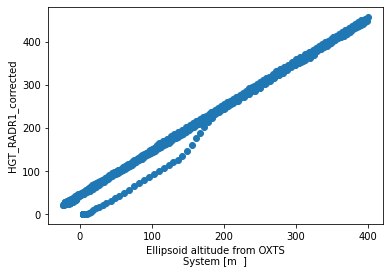

In [14]:
ds_lowlevel = ds.where(ds.ALT_OXTS < 400.0)

fig, ax = plt.subplots()
xr.plot.scatter(ds=ds_lowlevel, x="ALT_OXTS", y="HGT_RADR1_corrected")

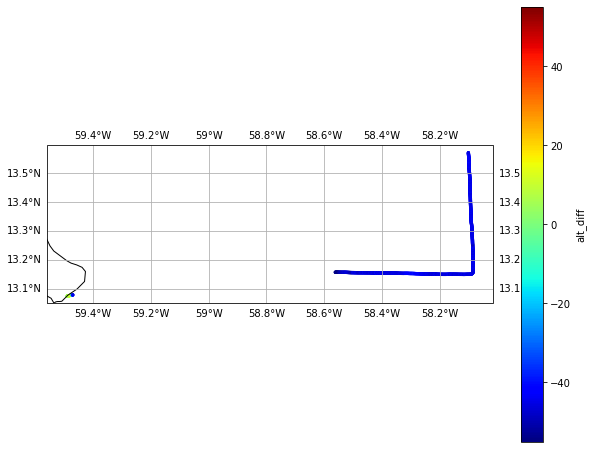

In [15]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds["alt_diff"] = ds.ALT_OXTS - ds.HGT_RADR1_corrected
ds_lowlevel = ds.where(ds.ALT_OXTS < 200.0)

xr.plot.scatter(
    ds=ds_lowlevel, x="LON_OXTS", y="LAT_OXTS", hue="alt_diff", cmap="jet", s=5.0
)

ax.gridlines(draw_labels=["left", "bottom"])
ax.coastlines(resolution="10m")

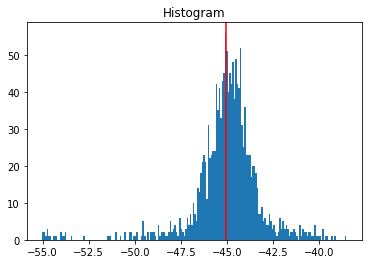

In [16]:
ds_lowlevel_ocean = ds.where(np.logical_and(ds.ALT_OXTS < 200.0, ds.LON_OXTS > -59.4))
da_ocean_offset = (
    ds_lowlevel_ocean.ALT_OXTS - ds_lowlevel_ocean.HGT_RADR1_corrected
).mean()

ds["ALT_OXTS_OFFSET"] = ds.ALT_OXTS - da_ocean_offset
z_threshold = 400
ds["alt_composite"] = ds.HGT_RADR1_corrected.where(
    ds.HGT_RADR1_corrected < z_threshold, ds.ALT_OXTS_OFFSET
)


_ = (ds_lowlevel_ocean.ALT_OXTS - ds_lowlevel_ocean.HGT_RADR1_corrected).plot.hist(
    bins=200
)
plt.gca().axvline(da_ocean_offset, color="red")

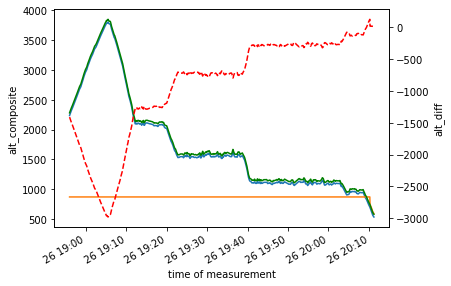

In [17]:
t_interval = (ds.time.max() - np.timedelta64(80, "m"), None)

ds["alt_diff"] = ds.HGT_RADR1_corrected - ds.alt_composite

ds_ = ds.sel(time=slice(*t_interval))
ds_.ALT_OXTS.plot()
ds_.HGT_RADR1_corrected.plot()
ds_.alt_composite.plot(color="green")
plt.gca().twinx()
ds_.alt_diff.plot(color="red", linestyle="--")

Text(0.5, 1.0, '333')

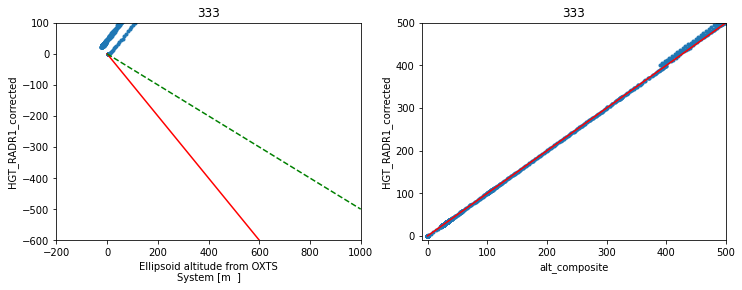

In [19]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)

ax = axes[0]
xr.plot.scatter(ds, "ALT_OXTS", "HGT_RADR1_corrected", marker=".", ax=ax)
ax.set_xlim(-200, 1000)
ax.set_ylim(-600, 100)
x = np.linspace(0, 1000, 100)
ax.plot(x, -x, color="red")
ax.plot(x, -0.5 * x, color="green", linestyle="--")
ax.set_title(flight_number)

ax = axes[1]
xr.plot.scatter(ds, "alt_composite", "HGT_RADR1_corrected", marker=".", ax=ax)
ax.set_xlim(-10, 500)
ax.set_ylim(-10, 500)
x = np.linspace(0, 1000, 100)
ax.plot(x, x, color="red")
ax.set_title(flight_number)

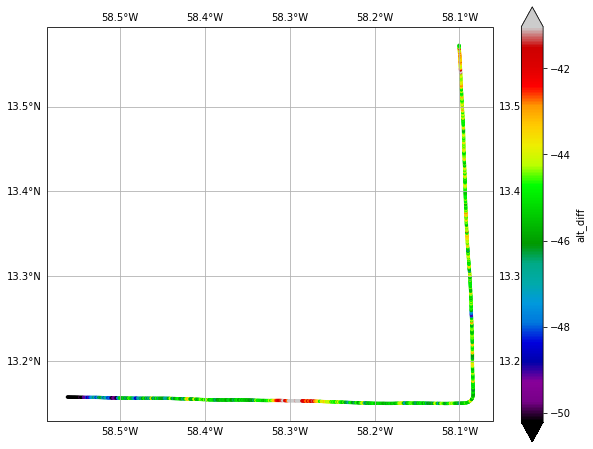

In [20]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))


xr.plot.scatter(
    ds=ds_lowlevel_ocean,
    x="LON_OXTS",
    y="LAT_OXTS",
    hue="alt_diff",
    cmap="nipy_spectral",
    s=5.0,
    robust=True,
)

ax.gridlines(draw_labels=["left", "bottom"])
ax.coastlines(resolution="10m")

Looking in ../../flight330/MASIN for EUREC4A_TO-330_MASIN-1Hz_*_*.nc
Looking in ../../flight331/MASIN for EUREC4A_TO-331_MASIN-1Hz_*_*.nc
Looking in ../../flight332/MASIN for EUREC4A_TO-332_MASIN-1Hz_*_*.nc
Looking in ../../flight333/MASIN for EUREC4A_TO-333_MASIN-1Hz_*_*.nc
Looking in ../../flight334/MASIN for EUREC4A_TO-334_MASIN-1Hz_*_*.nc
Looking in ../../flight335/MASIN for EUREC4A_TO-335_MASIN-1Hz_*_*.nc
Looking in ../../flight336/MASIN for EUREC4A_TO-336_MASIN-1Hz_*_*.nc
Looking in ../../flight337/MASIN for EUREC4A_TO-337_MASIN-1Hz_*_*.nc
Looking in ../../flight338/MASIN for EUREC4A_TO-338_MASIN-1Hz_*_*.nc
Looking in ../../flight339/MASIN for EUREC4A_TO-339_MASIN-1Hz_*_*.nc
Looking in ../../flight340/MASIN for EUREC4A_TO-340_MASIN-1Hz_*_*.nc
Looking in ../../flight341/MASIN for EUREC4A_TO-341_MASIN-1Hz_*_*.nc
Looking in ../../flight342/MASIN for EUREC4A_TO-342_MASIN-1Hz_*_*.nc
Looking in ../../flight343/MASIN for EUREC4A_TO-343_MASIN-1Hz_*_*.nc
Looking in ../../flight344/MASIN f

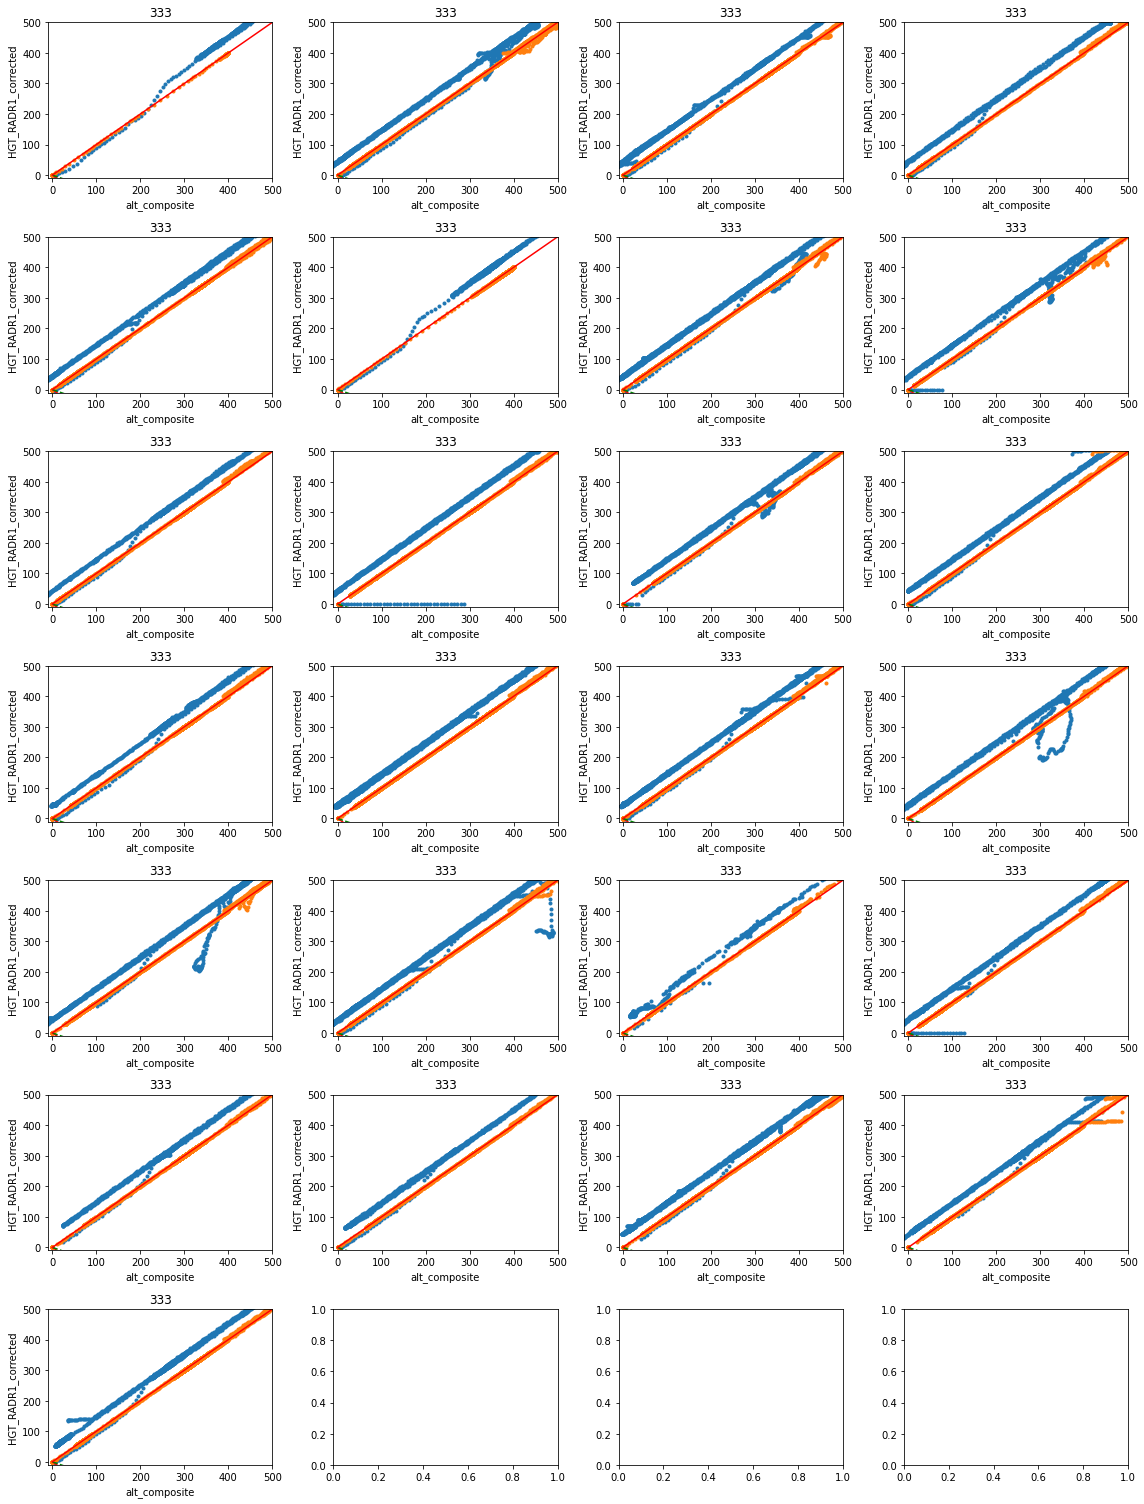

In [29]:
FLIGHT_NUMBERS = range(330, 355)
N_flights = 25
ncols = 4
nrows = N_flights // ncols
if ncols * nrows < N_flights:
    nrows += 1

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4 * ncols, 3 * nrows))


def add_alt_composite(ds):
    # find points at which twin-otter was flying low-level (below 200m) east of
    # Barbados (so we don't include the island)
    ds_lowlevel_ocean = ds.where(
        np.logical_and(ds.ALT_OXTS < 200.0, ds.LON_OXTS > -59.4)
    )
    # compute the mean offset between radar altitude and GPS when flying a low-level
    da_ocean_offset = (
        ds_lowlevel_ocean.ALT_OXTS - ds_lowlevel_ocean.HGT_RADR1_corrected
    ).mean()

    # create an offset GPS altitude which goes to zero at the ocean surface
    ds["ALT_OXTS_OFFSET"] = ds.ALT_OXTS - da_ocean_offset
    
    # us corrected radar altitude where it is below 400m otherwise use offset GPS
    z_threshold = 400
    ds["alt_composite"] = ds.HGT_RADR1_corrected.where(
        ds.HGT_RADR1_corrected < z_threshold, ds.ALT_OXTS_OFFSET
    )


for (ax, flight_num) in zip(axes.flatten(), FLIGHT_NUMBERS):
    ds = get_TO_data(flight_number=flight_num)

    ds["HGT_RADR1_corrected"] = -2.0 * ds.HGT_RADR1
    add_alt_composite(ds=ds)

    xr.plot.scatter(ds, "ALT_OXTS", "HGT_RADR1_corrected", marker=".", ax=ax)
    ax.set_xlim(-200, 1000)
    ax.set_ylim(-600, 100)
    x = np.linspace(0, 1000, 100)
    ax.plot(x, -x, color="red")
    ax.plot(x, -0.5 * x, color="green", linestyle="--")
    ax.set_title(flight_number)

    xr.plot.scatter(ds, "alt_composite", "HGT_RADR1_corrected", marker=".", ax=ax)
    ax.set_xlim(-10, 500)
    ax.set_ylim(-10, 500)
    x = np.linspace(0, 1000, 100)
    ax.plot(x, x, color="red")
    ax.set_title(flight_number)
fig.tight_layout()
# ax.set_xlim(0, 200)
# ax.set_ylim(-200, 20)
# fig.savefig("MASIN_OXTS_vs_RADAR_alt_comparison.png")

In [26]:
for v in ["ALT_OXTS", "HGT_RADR1", "HGT_RADR2"]:
    print(f"{v}: {ds_masin[v].long_name} [{ds_masin[v].units.strip()}]")

ALT_OXTS: Ellipsoid altitude from OXTS System [m]
HGT_RADR1: Radar height from the aircraft radar altimeter 1. [m]
HGT_RADR2: Radar height from the aircraft radar altimeter 2. [m]


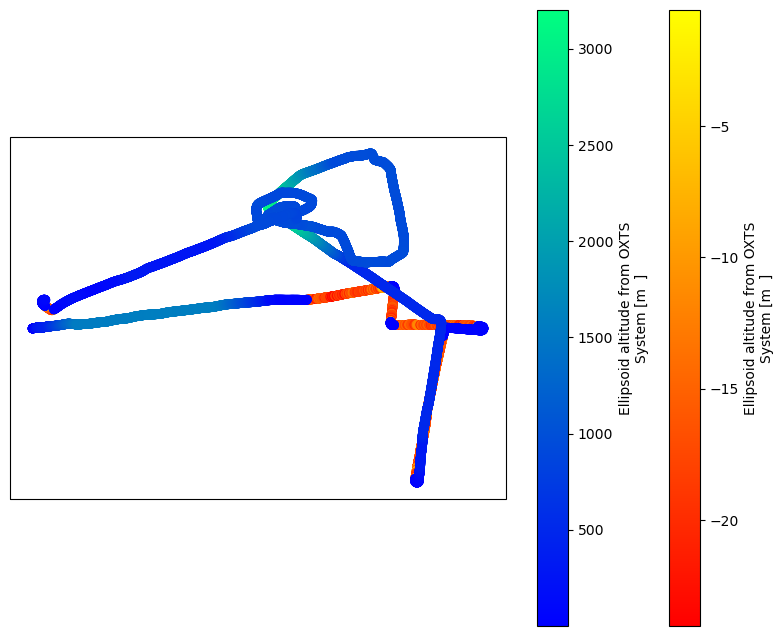

In [14]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

xr.plot.scatter(ds=ds.where(ds.alt < 0.0), x="lon", y="lat", hue="alt", cmap="autumn")
xr.plot.scatter(ds=ds.where(ds.alt > 0.0), x="lon", y="lat", hue="alt", cmap="winter")